#Environment Setup

In [ ]:
!git clone https://github.com/phantomcorn/open-musiclm.git
%cd open-musiclm
!pip install -e .
%cd ..

Cloning into 'open-musiclm'...
remote: Enumerating objects: 1333, done.
remote: Counting objects: 100% (306/306), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 1333 (delta 273), reused 233 (delta 233), pack-reused 1027
Receiving objects: 100% (1333/1333), 1.81 MiB | 27.60 MiB/s, done.
Resolving deltas: 100% (936/936), done.
/content/open-musiclm
Obtaining file:///content/open-musiclm
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 40.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.8/917.8 kB 72.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manyl

In [ ]:
import random
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
#------------------------------------------------------------------------------#
%cd open-musiclm
import os
import sys
import torch

from beartype.typing import List, Optional
import torchaudio
from einops import rearrange
import argparse
from pathlib import Path
from dataclasses import asdict, dataclass

from open_musiclm.laion_clap import CLAP_Module
from open_musiclm.config import load_model_config, create_musiclm_from_config
from open_musiclm.clap_quantized import ClapQuantized, create_clap_quantized
from open_musiclm.encodec_wrapper import EncodecWrapper, create_encodec_24khz
from open_musiclm.hf_hubert_kmeans import HfHubertWithKmeans, get_hubert_kmeans
from open_musiclm.open_musiclm import (MusicLM, TokenConditionedTransformer,
                           create_coarse_transformer, create_fine_transformer,
                           create_semantic_transformer)
import torch.nn as nn
import torch.nn.functional as F
%cd ..
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from torchvision.models import resnet18, resnet50,  ResNet18_Weights, ResNet50_Weights

/content/open-musiclm
/content


In [ ]:
def seed_torch_code(seed, strict=False):
    """Control pseudo-randomness for reproducibility.
    :param manual_seed: (int) random-seed
    :param strict: (boolean) if True, cudnn operates in a deterministic manner
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if strict:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed = 42
seed_torch_code(seed)

In [ ]:
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/Project"
IMEMNET_PATH = f'{PROJECT_PATH}/IMEMNet'

#Image-Sound

In [ ]:
class CDCML(nn.Module):

  def __init__(self, feat_dim: int = 512):
    super().__init__()
    self.resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)
    self.resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

    #Remove last FC layer
    # self.resnet50.fc = nn.Identity()
    self.resnet18.fc = nn.Identity()
    self.resnet50.fc = nn.Identity()

    #Add our own FC layer
    self.img_feat_extractor = nn.Sequential(
        self.resnet50,
        nn.Linear(2048, feat_dim)
    )

    self.music_feat_extractor = nn.Sequential(
        self.resnet18,
        nn.Linear(512, feat_dim)
    )

    self.va_predictor = nn.Sequential(
        nn.Linear(feat_dim, feat_dim),
        nn.BatchNorm1d(feat_dim),
        nn.ReLU(),
        nn.Linear(feat_dim, feat_dim),
        nn.BatchNorm1d(feat_dim),
        nn.ReLU(),
        nn.Linear(feat_dim, 2),
        nn.BatchNorm1d(2),
        nn.Sigmoid()
    )

    self.sim_predictor = nn.Sequential(
        nn.Linear(feat_dim * 2, feat_dim),
        nn.BatchNorm1d(feat_dim),
        nn.ReLU(),
        nn.Linear(feat_dim, feat_dim),
        nn.BatchNorm1d(feat_dim),
        nn.ReLU(),
        nn.Linear(feat_dim, 1),
        nn.BatchNorm1d(1),
        nn.Sigmoid()
    )

  def forward(self, x):

    wav_feat, img = x
    wav_emb = self.music_feat_extractor(wav_feat) #(batch_size, 512)
    img_emb = self.img_feat_extractor(img)      #(batch_size, 512)

    emb_concat = torch.cat([wav_emb, img_emb],dim=1)
    sim_pred = self.sim_predictor(emb_concat)
    wav_va_pred = self.va_predictor(wav_emb)
    img_va_pred = self.va_predictor(img_emb)

    return wav_emb, img_emb, sim_pred, wav_va_pred, img_va_pred

  def compute_joint_emb(self,img=None, wav=None):

    if img is not None:
      return self.img_feat_extractor(img)
    if wav is not None:
      return self.music_feat_extractor(img)


In [ ]:
fname = "epoch=002_tr_loss=5079.029297.pth"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

def get_model_ckpt(fname=None):

  cdcml = CDCML()
  optimizer = torch.optim.SGD(cdcml.parameters(), lr= 1e-3)
  scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
  if fname!= None:
    print("Loading from checkpoint " + fname)
    ckpt = torch.load(f'{IMEMNET_PATH}/output/{fname}', map_location=torch.device(device))

    cdcml.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    scheduler.load_state_dict(ckpt['scheduler_state_dict'])
  return cdcml, optimizer, scheduler

def get_prev_losses(fname=None):
  if fname != None:
    ckpt = torch.load(f'{IMEMNET_PATH}/output/{fname}', map_location=torch.device(device))
    return ckpt['losses'],ckpt['losses_cfr'], ckpt['losses_cfm'], ckpt['losses_sfr_i'], ckpt["losses_sfr_m"], ckpt['losses_sim'], ckpt['losses_iva'], ckpt['losses_mva']
  else :
    return [],[],[],[],[],[],[],[]

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

cdcml, optimizer, scheduler = get_model_ckpt(fname)
cdcml = cdcml.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 24.7MB/s]


Loading from checkpoint epoch=002_tr_loss=5079.029297.pth


In [ ]:
df = pd.read_csv(f'{PROJECT_PATH}/Audible-Visual/most_similar_subsample.csv')

already_generated_fnames = os.listdir(f'{PROJECT_PATH}/Audible-Visual/end2end/most_similar_output')
already_generated_fnames = list(map(lambda fnames: fnames.split(".")[0], already_generated_fnames))
df = df[~df.IMG_FILE.isin(already_generated_fnames)]

In [ ]:
%cd open-musiclm
from open_musiclm.model_types import NeuralCodec, Wav2Vec
from open_musiclm.open_musiclm import SemanticStage, CoarseStage, FineStage, get_or_compute_semantic_token_ids,get_or_compute_acoustic_token_ids
from open_musiclm.utils import (beartype_jit, eval_decorator, exists, prepare_audio, float32_to_int16, int16_to_float32)
from einops import repeat
from torchaudio.functional import resample
%cd ..

/content/open-musiclm
/content


In [ ]:
#---------------------------------------MODIFIED-FUNCTION(originally passed into CLAP)--------------
@beartype_jit
def get_or_compute_clap_token_ids(clap_token_ids: Optional[torch.Tensor], cdcml, conditioning_audio: Optional[torch.Tensor], conditioning_img: Optional[torch.Tensor]):
    if not exists(clap_token_ids):
        assert exists(conditioning_audio) ^ exists(conditioning_img), "either condition on text or audio"
        assert exists(clap)
        if exists(conditioning_img):
            embedding = cdcml.compute_joint_emb(img=conditioning_img)

    return rvq(embedding, return_rvq_loss=False)
#---------------------------------------------------------------------------------------------------

In [20]:
@beartype_jit
class MusicLM(nn.Module):
    def __init__(
        self,
        *,
        wav2vec: Optional[Wav2Vec] = None,
        cdcml: CDCML,
        neural_codec: NeuralCodec,
        semantic_transformer: TokenConditionedTransformer,
        coarse_transformer: TokenConditionedTransformer,
        fine_transformer: TokenConditionedTransformer
    ):
        super().__init__()

        assert semantic_transformer.token_sequences[1].codebook_size == coarse_transformer.token_sequences[1].codebook_size
        assert coarse_transformer.token_sequences[2].codebook_size == fine_transformer.token_sequences[2].codebook_size
        assert coarse_transformer.token_sequences[2].num_quantizers == fine_transformer.token_sequences[1].num_quantizers

        self.semantic = SemanticStage(
            semantic_transformer=semantic_transformer,
            wav2vec=wav2vec,
            clap=clap,
        )

        self.coarse = CoarseStage(
            coarse_transformer=coarse_transformer,
            wav2vec=wav2vec,
            clap=clap,
            neural_codec=neural_codec
        )

        self.fine = FineStage(
            fine_transformer=fine_transformer,
            clap=clap,
            neural_codec=neural_codec
        )

        self.wav2vec = wav2vec
        self.cdcml = cdcml
        self.neural_codec = neural_codec

    @property
    def device(self):
        return next(self.parameters()).device

    @eval_decorator
    @torch.no_grad()
    def forward(
        self,
        *,
        img: Optional[torch.Tensor] = None,
        prime_wave=None,
        prime_wave_sample_hz=None,
        output_seconds=8,
        semantic_window_seconds=10,
        coarse_window_seconds=4,
        fine_window_seconds=2,
        semantic_steps_per_second=50, # Note: for MERTv0 its actually 50 * seconds - 1
        acoustic_steps_per_second=75, # 75 for encodec, 50 for soundstream
        return_coarse_generated_wave=False,
        mask_out_generated_fine_tokens=False,
        semantic_sliding_window_step_percent=0.5,
        coarse_sliding_window_step_percent=0.5,
        fine_sliding_window_step_percent=1,
    ):
        assert exists(img), 'image needs to be passed in if one of the transformer requires conditioning'

        #-----------------------------------------------------MODIFIED-----------------------------------------------------------
        clap_token_ids = get_or_compute_clap_token_ids(None, self.cdcml, conditioning_audio=None, conditioning_img=img)
        #------------------------------------------------------------------------------------------------------------------------
        # compute everything we need for audio continuation

        all_audio_condition_coarse_token_ids = None
        all_audio_condition_fine_token_ids = None
        audio_condition_semantic_token_ids = None
        audio_condition_coarse_token_ids = None
        audio_condition_fine_token_ids = None
        semantic_token_adjustment = 0 # used to crop generated semantic tokens so first sequence lines up with first coarse tokens sequence
        coarse_token_adjustment = 0
        fine_token_adjustment = 0
        if exists(prime_wave):
            assert exists(prime_wave_sample_hz)
            prime_wave_wav2vec = prepare_audio(
                prime_wave,
                prime_wave_sample_hz,
                self.wav2vec.target_sample_hz,
                normalize=True,
                target_length_seconds=semantic_window_seconds)
            prime_wave_encodec = prepare_audio(
                prime_wave,
                prime_wave_sample_hz,
                self.neural_codec.sample_rate,
                normalize=False,
                target_length_seconds=semantic_window_seconds)

            condition_semantic_token_ids = get_or_compute_semantic_token_ids(None, prime_wave_wav2vec, self.wav2vec)
            condition_coarse_token_ids, condition_fine_token_ids = get_or_compute_acoustic_token_ids(None, None, prime_wave_encodec, self.neural_codec, self.coarse.transformer_wrapper.token_sequences[2].num_quantizers)
            condition_semantic_length = int(semantic_steps_per_second * semantic_window_seconds * (1 - semantic_sliding_window_step_percent))
            condition_coarse_length = int(acoustic_steps_per_second * coarse_window_seconds * (1 - coarse_sliding_window_step_percent))
            condition_fine_length = int(acoustic_steps_per_second * fine_window_seconds * (1 - fine_sliding_window_step_percent))

            all_audio_condition_coarse_token_ids = condition_coarse_token_ids
            all_audio_condition_fine_token_ids = condition_fine_token_ids

            audio_condition_semantic_token_ids = condition_semantic_token_ids[:, -condition_semantic_length:] if condition_semantic_token_ids.shape[1] >= condition_semantic_length else condition_semantic_token_ids
            audio_condition_coarse_token_ids = condition_coarse_token_ids[:, -condition_coarse_length:]
            audio_condition_fine_token_ids = condition_fine_token_ids[:, -condition_fine_length:] if condition_fine_length > 0 else None

            semantic_token_adjustment = condition_semantic_length - int(semantic_steps_per_second * coarse_window_seconds * (1 - coarse_sliding_window_step_percent))
            coarse_token_adjustment = condition_coarse_length - int(acoustic_steps_per_second * fine_window_seconds * (1 - fine_sliding_window_step_percent))
            fine_token_adjustment = condition_fine_length

        # semantic stage

        all_semantic_token_ids = self.semantic.generate(
            clap_token_ids=clap_token_ids,
            semantic_token_ids=audio_condition_semantic_token_ids,
            max_time_steps=int(min(output_seconds, semantic_window_seconds) * semantic_steps_per_second),
            include_eos_in_output=False,
            append_eos_to_conditioning_tokens=True,
        )

        while all_semantic_token_ids.shape[1] < int(output_seconds * semantic_steps_per_second):
            condition_length = int(semantic_window_seconds * semantic_steps_per_second * (1 - semantic_sliding_window_step_percent))
            condition_semantic_token_ids = all_semantic_token_ids[:, -condition_length:]
            pred_semantic_token_ids = self.semantic.generate(
                clap_token_ids=clap_token_ids,
                semantic_token_ids=condition_semantic_token_ids,
                max_time_steps=int(semantic_window_seconds * semantic_steps_per_second),
                include_eos_in_output=False,
                append_eos_to_conditioning_tokens=True,
            )
            pred_semantic_token_ids = pred_semantic_token_ids[:, condition_length:]
            all_semantic_token_ids = torch.cat([all_semantic_token_ids, pred_semantic_token_ids], dim=1)

        # crop semantic tokens to line up with coarse tokens
        all_semantic_token_ids = all_semantic_token_ids[:, semantic_token_adjustment:]

        # coarse stage

        window_size = int(coarse_window_seconds * semantic_steps_per_second - 1)
        step_size = int(window_size * coarse_sliding_window_step_percent)
        all_semantic_token_ids = all_semantic_token_ids.unfold(1, window_size, step_size)
        all_semantic_token_ids = rearrange(all_semantic_token_ids, 'b n q w -> n b w q')

        all_coarse_token_ids = None
        for semantic_token_ids in all_semantic_token_ids:
            if exists(all_coarse_token_ids):
                condition_length = int(coarse_window_seconds * acoustic_steps_per_second * (1 - coarse_sliding_window_step_percent))
                condition_coarse_token_ids = all_coarse_token_ids[:, -condition_length:]
            else:
                condition_coarse_token_ids = audio_condition_coarse_token_ids

            pred_coarse_token_ids = self.coarse.generate(
                clap_token_ids=clap_token_ids,
                semantic_token_ids=semantic_token_ids,
                coarse_token_ids=condition_coarse_token_ids,
                max_time_steps=int(coarse_window_seconds * acoustic_steps_per_second),
                reconstruct_wave=False,
                include_eos_in_output=False,
                append_eos_to_conditioning_tokens=True,
                temperature=0.95,
            )

            if not exists(all_coarse_token_ids):
                all_coarse_token_ids = pred_coarse_token_ids
            else:
                pred_coarse_token_ids = pred_coarse_token_ids[:, condition_length:]
                all_coarse_token_ids = torch.cat([all_coarse_token_ids, pred_coarse_token_ids], dim=1)

        if return_coarse_generated_wave:
            wave = self.neural_codec.decode_from_codebook_indices(all_coarse_token_ids)
            wave = rearrange(wave, 'b 1 n -> b n')
            return wave

        # crop coarse tokens to line up with fine tokens
        all_coarse_token_ids = all_coarse_token_ids[:, coarse_token_adjustment:]

        # fine stage

        fine_window_size = int(fine_window_seconds * acoustic_steps_per_second)
        fine_step_size = int(fine_window_size * fine_sliding_window_step_percent)
        all_coarse_token_ids_unfolded = all_coarse_token_ids.unfold(1, fine_window_size, fine_step_size)
        all_coarse_token_ids_unfolded = rearrange(all_coarse_token_ids_unfolded, 'b n q w -> n b w q')

        all_fine_token_ids = None
        for coarse_token_ids in all_coarse_token_ids_unfolded:
            if exists(all_fine_token_ids):
                condition_length = int(fine_window_size * (1 - fine_sliding_window_step_percent))
                condition_fine_token_ids = all_fine_token_ids[:, -condition_length:] if condition_length > 0 else None
            else:
                condition_fine_token_ids = audio_condition_fine_token_ids

            pred_fine_token_ids = self.fine.generate(
                clap_token_ids=clap_token_ids,
                coarse_token_ids=coarse_token_ids,
                fine_token_ids=condition_fine_token_ids,
                max_time_steps=fine_window_size,
                reconstruct_wave=False,
                include_eos_in_output=False,
                append_eos_to_conditioning_tokens=True,
                temperature=0.4,
            )
            if not exists(all_fine_token_ids):
                all_fine_token_ids = pred_fine_token_ids
            else:
                pred_fine_token_ids = pred_fine_token_ids[:, condition_length:]
                all_fine_token_ids = torch.cat([all_fine_token_ids, pred_fine_token_ids], dim=1)

        # crop fine tokens to remove conditioning audio
        all_fine_token_ids = all_fine_token_ids[:, fine_token_adjustment:]

        if exists(all_audio_condition_coarse_token_ids) and exists(all_audio_condition_fine_token_ids):
            all_fine_token_ids = torch.cat([all_audio_condition_fine_token_ids, all_fine_token_ids], dim=1)
            all_coarse_token_ids = torch.cat([all_audio_condition_coarse_token_ids, all_coarse_token_ids], dim=1)

        all_acoustic_token_ids = torch.cat([all_coarse_token_ids, all_fine_token_ids], dim=-1)
        wave = self.neural_codec.decode_from_codebook_indices(all_acoustic_token_ids)
        wave = rearrange(wave, 'b 1 n -> b n')
        return wave

    # @torch.no_grad()
    # def generate_top_match(
    #     self,
    #     *,
    #     text: List[str],
    #     num_samples=4,
    #     num_top_matches: int=1,
    #     **kwargs
    # ):
    #     """
    #     Generates samples, then uses CLAP to identify the best matches to the text.

    #     Returns a list of generated waves and a list of their topk cosine similarity scores.
    #     """
    #     all_samples = []
    #     all_similarities = []
    #     for prompt in text:
    #         text_input = [prompt for _ in range(num_samples)]
    #         samples = self.forward(text=text_input, **kwargs)

    #         text_latents = self.clap(text_input=[prompt], return_embedding=True)
    #         text_latents = repeat(text_latents, 'b d -> (repeat b) d', repeat=num_samples)

    #         clap_input = resample(samples, self.neural_codec.sample_rate, self.clap.sample_rate)
    #         clap_input = int16_to_float32(float32_to_int16(clap_input))
    #         audio_latents = self.clap(audio_input=clap_input, return_embedding=True)

    #         sim = F.cosine_similarity(text_latents, audio_latents, dim=-1)
    #         top_matches = sim.topk(num_top_matches, dim=0, sorted=True).indices

    #         all_similarities.append(sim[top_matches].detach().cpu())
    #         all_samples.append(samples[top_matches])

    #     return all_samples, all_similarities


In [ ]:
class disable_print:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

def load_model(model, path):
    """helper class to load a model checkpoint"""
    path = Path(path)
    assert path.exists(), f'checkpoint does not exist at {str(path)}'
    pkg = torch.load(str(path))
    model.load_state_dict(pkg)



MUSICLM_PATH = "/content/drive/MyDrive/Colab Notebooks/Project/Open-MusicLM/"
MUSICLM_MODEL_PATH = MUSICLM_PATH + "musiclm_large_small_context.json"
SEMANTIC_PATH = MUSICLM_PATH + "semantic.transformer.14000.pt"
COARSE_PATH = MUSICLM_PATH + "coarse.transformer.18000.pt"
FINE_PATH = MUSICLM_PATH + "fine.transformer.24000.pt"
CLAP_PATH = MUSICLM_PATH  + "630k-audioset-best-modified.pt" #"music_audioset_epoch_15_esc_90.14.pt"
RVQ_PATH = MUSICLM_PATH + "clap.rvq.950_no_fusion.pt"
KMEANS_PATH = MUSICLM_PATH + "kmeans_10s_no_fusion.joblib"

model_config = load_model_config(MUSICLM_MODEL_PATH)
model_config.clap_rvq_cfg.checkpoint_path = CLAP_PATH
model_config.clap_rvq_cfg

ClapRVQConfig(rq_num_quantizers=12, codebook_size=1024, enable_fusion=False, rq_ema_decay=0.95, threshold_ema_dead_code=0.5, checkpoint_path='/content/drive/MyDrive/Colab Notebooks/Project/Open-MusicLM/630k-audioset-best-modified.pt', amodel_type='HTSAT-tiny')

In [ ]:
def create_clap_quantized(
    device=None,
    learn_rvq=False,
    enable_fusion=False,
    rvq_checkpoint_path=None,
    checkpoint_path: Optional[str] = None,
    amodel_type: str = 'HTSAT-tiny',
    **kwargs
):
    # print(checkpoint_path)
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    clap = CLAP_Module(enable_fusion=enable_fusion, device=device, amodel=amodel_type)
    clap.load_ckpt(ckpt=checkpoint_path)

    clap_quantized = ClapQuantized(clap=clap, learn_rvq=learn_rvq, **kwargs)

    if exists(rvq_checkpoint_path):
        rvq = torch.load(rvq_checkpoint_path, map_location=device)
        clap_quantized.rq.load_state_dict(rvq)

    return clap_quantized

clap_quantized = create_clap_quantized(**asdict(model_config.clap_rvq_cfg),
            device=device,
            learn_rvq=False,
            rvq_checkpoint_path=RVQ_PATH,
        ).to(device)

clap = clap_quantized.clap
rvq = clap_quantized.quantize

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


Load the specified checkpoint /content/drive/MyDrive/Colab Notebooks/Project/Open-MusicLM/630k-audioset-best-modified.pt from users.
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.p

We replace CLAP (Joint Text-Audio space) with CDCML(Joint Image-Music space)

In [ ]:
wav2vec = get_hubert_kmeans(
        **asdict(model_config.hubert_kmeans_cfg),
        kmeans_path=KMEANS_PATH
    ).to(device)

config.json:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

You are using a model of type mert_model to instantiate a model of type hubert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of HubertModel were not initialized from the model checkpoint at m-a-p/MERT-v0 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MiniBatchKMeans from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
encodec_wrapper = create_encodec_24khz(**asdict(model_config.encodec_cfg)).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Downloading: "https://dl.fbaipublicfiles.com/encodec/v0/encodec_24khz-d7cc33bc.th" to /root/.cache/torch/hub/checkpoints/encodec_24khz-d7cc33bc.th
100%|██████████| 88.9M/88.9M [00:00<00:00, 132MB/s]


In [ ]:
semantic_transformer = create_semantic_transformer(
      **asdict(model_config.semantic_cfg),
      clap_codebook_size=model_config.clap_rvq_cfg.codebook_size,
      semantic_codebook_size=model_config.hubert_kmeans_cfg.codebook_size,
      num_clap_quantizers=model_config.clap_rvq_cfg.rq_num_quantizers
    ).to(device)

load_model(semantic_transformer, SEMANTIC_PATH)

In [ ]:
coarse_transformer = create_coarse_transformer(
        **asdict(model_config.coarse_cfg),
        clap_codebook_size=model_config.clap_rvq_cfg.codebook_size,
        semantic_codebook_size=model_config.hubert_kmeans_cfg.codebook_size,
        acoustic_codebook_size=model_config.encodec_cfg.codebook_size,
        num_clap_quantizers=model_config.clap_rvq_cfg.rq_num_quantizers,
        num_coarse_quantizers=model_config.global_cfg.num_coarse_quantizers,
    ).to(device)

load_model(coarse_transformer, COARSE_PATH)

In [ ]:
fine_transformer = create_fine_transformer(
        **asdict(model_config.fine_cfg),
        clap_codebook_size=model_config.clap_rvq_cfg.codebook_size,
        acoustic_codebook_size=model_config.encodec_cfg.codebook_size,
        num_clap_quantizers=model_config.clap_rvq_cfg.rq_num_quantizers,
        num_coarse_quantizers=model_config.global_cfg.num_coarse_quantizers,
        num_fine_quantizers=model_config.global_cfg.num_fine_quantizers
    ).to(device)

load_model(fine_transformer, FINE_PATH)

In [21]:
musiclm = MusicLM(
        wav2vec=wav2vec,
        cdcml=cdcml,
        neural_codec=encodec_wrapper,
        semantic_transformer=semantic_transformer,
        coarse_transformer=coarse_transformer,
        fine_transformer=fine_transformer
    ).to(device)

In [ ]:
# rec = df.iloc[0]
# img_path = "/".join([IMEMNET_PATH,rec.img_from_folder,"images",rec.IMG_FILE+".jpg"])

In [22]:
img_preprocess = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Resize((224,224))
])

def load_img(img_path):

    img = img_preprocess(Image.open(img_path).convert('RGB'))

    return img.type(torch.float32)

In [24]:
duration = 8
return_coarse_wave = True
for row in df.iterrows():
  row = row[1]
  img_path = "/".join([IMEMNET_PATH,row.img_from_folder,"images",row.IMG_FILE+".jpg"])
  img = load_img(img_path).to(device).unsqueeze(0)
  painting = row.IMG_FILE

  generated_wave = musiclm.forward(
              img=img,
              output_seconds=duration,
              semantic_window_seconds=model_config.global_cfg.semantic_audio_length_seconds,
              coarse_window_seconds=model_config.global_cfg.coarse_audio_length_seconds,
              fine_window_seconds=model_config.global_cfg.fine_audio_length_seconds,
              semantic_steps_per_second=model_config.hubert_kmeans_cfg.output_hz,
              acoustic_steps_per_second=model_config.encodec_cfg.output_hz,
              return_coarse_generated_wave=return_coarse_wave,
          ).detach().cpu()

  # print(generated_wave.shape)
  torchaudio.save(f'{PROJECT_PATH}/Audible-Visual/end2end/most_similar_output/{painting}.wav', generated_wave, musiclm.neural_codec.sample_rate)
  print(f'{painting}.wav saved!')
  break

generating predicted tokens: 100%|██████████| 150/150 [02:35<00:00,  1.04s/it]


COCO_train2014_000000199640.wav saved!


In [ ]:
torchaudio.save(f'{PROJECT_PATH}/new_dataset/random_similar_output/{row[1].painting}.wav', generated_wave, musiclm.neural_codec.sample_rate)

In [ ]:
  torchaudio.save(f'{PROJECT_PATH}/Audible-Visual/end2end/most_similar_output/{painting}.wav', generated_wave, musiclm.neural_codec.sample_rate)

#Evaluation

##Frechet Audio Distance

In [ ]:
!pip install frechet_audio_distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 24.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of laion-clap to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
import torchaudio
import os
import random
import torch
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/Project"

In [ ]:
gen_audio_dir = f'{PROJECT_PATH}/new_dataset/open-musiclm/most_similar_output/1s_audio_every_500ms'
bg_audio_dir = f'{PROJECT_PATH}/FMA/1s_audio_every_500ms'
bg_embs_save_path = f'{PROJECT_PATH}/new_dataset/fma_bg_emb.npy'

In [ ]:
from frechet_audio_distance import FrechetAudioDistance

# to use `vggish`
frechet = FrechetAudioDistance(
    model_name="vggish",
    sample_rate=16000,
    use_pca=False,
    use_activation=False,
    verbose=False
)

fad = frechet.score(
    bg_audio_dir,
    gen_audio_dir,
    bg_embs_save_path,
    None
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/harritaylor/torchvggish/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/harritaylor/torchvggish/releases/download/v0.1/vggish-10086976.pth" to /root/.cache/torch/hub/checkpoints/vggish-10086976.pth
100%|██████████| 275M/275M [00:02<00:00, 131MB/s]
Downloading: "https://github.com/ha

Background : MusicCaps

In [ ]:
fad

13.278339375390009913

Background : FMA

In [ ]:
fad

11.86298855837505669

##KL Divergence (Most similar)

We compare the probability distribution obtained from passing the audio file into a Music-genre classifier (https://huggingface.co/SeyedAli/Musical-genres-Classification-Hubert-V1)

In [ ]:
!pip install datasets

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline, AutoConfig
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset, Audio
import os
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np


sample_rate = 16000
config = AutoConfig.from_pretrained("SeyedAli/Musical-genres-Classification-Hubert-V1")
idx2label = config.id2label
label2idx = config.label2id
pipe = pipeline("audio-classification", model="SeyedAli/Musical-genres-Classification-Hubert-V1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at SeyedAli/Musical-genres-Classification-Hubert-V1 were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForS

In [ ]:
NEWDSET_PATH = "/content/drive/MyDrive/Colab Notebooks/Project/new_dataset" #Generated audio subdir

pairs_df = pd.read_csv(f'{NEWDSET_PATH}/most_similar_subsample.csv')

Build dataset

In [ ]:
gen_audio_subdir = f'{NEWDSET_PATH}/open-musiclm/most_similar_output'
gen_fnames = os.listdir(gen_audio_subdir)
ref_audio_subdir = "/content/drive/MyDrive/Colab Notebooks/Project/IMEMNet/cut_audio"

ref_fnames = []
sim_scores = []
for gen_fname in gen_fnames:
  #Get corresponding ref audio name
  top_row = pairs_df[pairs_df.IMG_FILE == gen_fname.split(".")[0]].sort_values(by=["score", "euclid_dist"],ascending=False).iloc[0]
  ref_fnames.append(top_row.WAV_FILE)
  sim_scores.append(top_row.score)

ref_audio_paths = list(map(lambda fname : f'{ref_audio_subdir}/{fname}.wav',ref_fnames))
gen_audio_paths = list(map(lambda fname : f'{gen_audio_subdir}/{fname}',gen_fnames))


audio_dataset = Dataset.from_dict(
    {"gen_audio": gen_audio_paths,
     "ref_audio": ref_audio_paths,
     "sim_score": sim_scores
    }).cast_column(
        "gen_audio", Audio(sampling_rate = sample_rate)
    ).cast_column(
        "ref_audio", Audio(sampling_rate = sample_rate)
    )

print(len(audio_dataset))

50


In [ ]:
def two_second_window(x,sr):
  num_splits = x.size//sr
  idx = np.random.randint(num_splits - 1)
  return x[idx*sr: (idx+2)*sr]

kl_avg = 0
kl = []
similarity = []
for input in audio_dataset:
  with torch.no_grad():
    ref_audio = input['ref_audio']['array']
    ref_audio_preprocess = pipe.preprocess(ref_audio)
    ref_audio_logits = pipe._forward(ref_audio_preprocess).logits
    ref_audio_dist = ref_audio_logits.softmax(-1)

    gen_audio = two_second_window(input['gen_audio']['array'], sample_rate)
    assert(gen_audio.shape == ref_audio.shape)
    gen_audio_preprocess = pipe.preprocess(gen_audio)
    gen_audio_logits = pipe._forward(gen_audio_preprocess).logits
    gen_audio_dist = gen_audio_logits.softmax(-1)

    curr_kl = F.kl_div(ref_audio_dist, gen_audio_dist, log_target=True, reduction="batchmean")

    kl.append(curr_kl)
    similarity.append(input['sim_score'])
    kl_avg += curr_kl

kl_avg /= len(audio_dataset)
kl_avg

tensor(0.6668)

(0.0, 1.0)

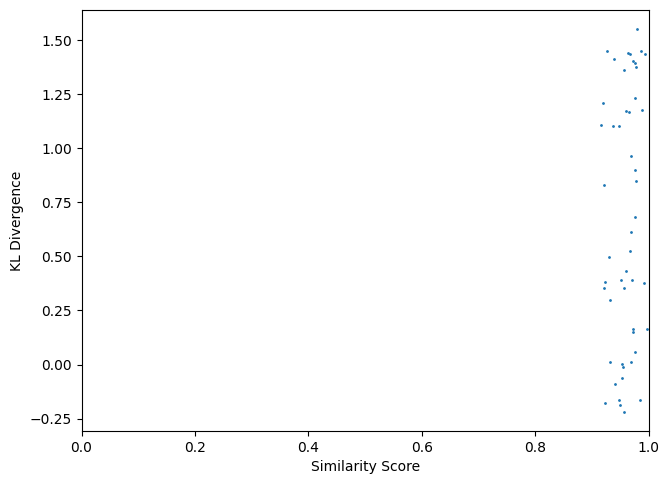

In [ ]:
fig,ax = plt.subplots(1)
fig.tight_layout()

ax.set_xlabel("Similarity Score")
ax.set_ylabel("KL Divergence")
ax.scatter(similarity, kl, s=1)
plt.xlim(0,1)

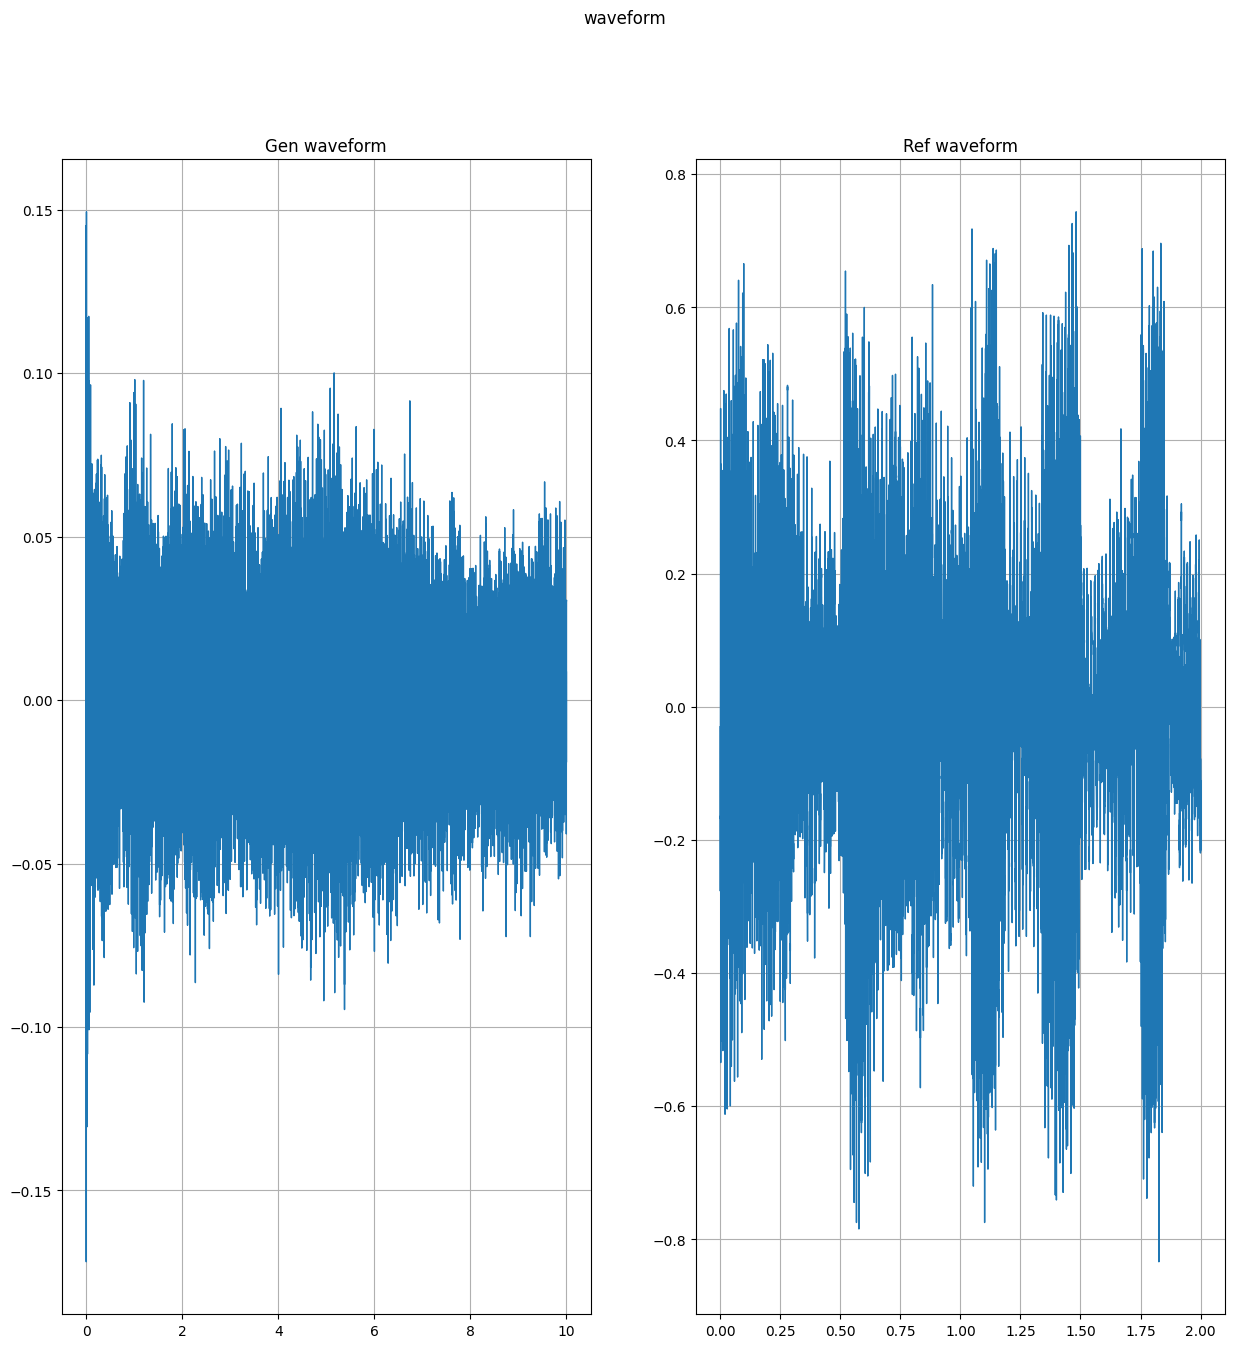

In [ ]:
def load_wave(idx):
    img_name = prompt_df.iloc[idx].painting
    gen_audio_path = f'{gen_audio_dir}/{img_name}.wav'
    gen_waveform, gen_sr = torchaudio.load(gen_audio_path)

    pair_data = pairs_df[pairs_df.IMG_FILE == img_name].sort_values(by=["score", "euclid_dist"],ascending=False).iloc[0]
    ref_audio_path = f'{ref_audio_dir}/{pair_data.WAV_FILE}.wav'
    ref_waveform, ref_sr = torchaudio.load(ref_audio_path)

    return gen_waveform, gen_sr, ref_waveform, ref_sr

def plot_gen_waveform(gen_wave, gen_sr, ref_wave, ref_sr):

    gen_waveform = gen_wave.numpy()
    _, gen_num_frames = gen_waveform.shape

    ref_waveform = ref_wave.numpy()
    _, ref_num_frames = ref_waveform.shape

    gen_time_axis = torch.arange(0, gen_num_frames) / gen_sr
    ref_time_axis = torch.arange(0, ref_num_frames) / ref_sr

    waveform = [gen_waveform, ref_waveform]
    time_axis = [gen_time_axis, ref_time_axis]
    title = ["Gen waveform", "Ref waveform"]

    figure, axes = plt.subplots(1,2, figsize=(15,15))

    for i,wave in enumerate(waveform):
        axes[i].plot(time_axis[i], wave[0], linewidth=1)
        axes[i].grid(True)
        axes[i].set_title(title[i])


    figure.suptitle("waveform")

gen_wave, gen_sr, ref_wave, ref_sr = load_wave(1)
plot_gen_waveform(gen_wave, gen_sr, ref_wave, ref_sr)


##KL Divergence (Random similar)

Plot graph similarity against KL measured

In [ ]:
!pip install datasets

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline, AutoConfig
from transformers.pipelines.pt_utils import KeyDataset
import pandas as pd
from datasets import Dataset, Audio
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

sample_rate = 16000
config = AutoConfig.from_pretrained("SeyedAli/Musical-genres-Classification-Hubert-V1")
idx2label = config.id2label
label2idx = config.label2id
pipe = pipeline("audio-classification", model="SeyedAli/Musical-genres-Classification-Hubert-V1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at SeyedAli/Musical-genres-Classification-Hubert-V1 were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForS

In [ ]:
NEWDSET_PATH = "/content/drive/MyDrive/Colab Notebooks/Project/new_dataset" #Generated audio subdir

pairs_df = pd.read_csv(f'{NEWDSET_PATH}/random_similar_subsample.csv')

In [ ]:
gen_audio_subdir = f'{NEWDSET_PATH}/random_similar_output'
ref_audio_subdir = "/content/drive/MyDrive/Colab Notebooks/Project/IMEMNet/cut_audio"
gen_fnames = os.listdir(gen_audio_subdir)

ref_fnames = []
sim_scores = []
for gen_fname in gen_fnames:
  top_row = pairs_df[pairs_df.IMG_FILE == gen_fname.split(".")[0]].sort_values(by=["score", "euclid_dist"],ascending=False).iloc[0]
  ref_fnames.append(top_row.WAV_FILE)
  sim_scores.append(top_row.score)

ref_audio_paths = list(map(lambda fname : f'{ref_audio_subdir}/{fname}.wav',ref_fnames))
gen_audio_paths = list(map(lambda fname : f'{gen_audio_subdir}/{fname}',gen_fnames))


audio_dataset = Dataset.from_dict(
    {"gen_audio": gen_audio_paths,
     "ref_audio": ref_audio_paths,
     "sim_score": sim_scores
    }).cast_column(
        "gen_audio", Audio(sampling_rate = sample_rate)
    ).cast_column(
        "ref_audio", Audio(sampling_rate = sample_rate)
    )

print(len(audio_dataset))

In [ ]:
def two_second_window(x,sr):
  num_splits = x.size//sr
  idx = np.random.randint(num_splits - 1)
  return x[idx*sr: (idx+2)*sr]

kl = []
similarity = []

kl_total = 0
for input in audio_dataset:
  with torch.no_grad():
    ref_audio = input['ref_audio']['array']
    ref_audio_preprocess = pipe.preprocess(ref_audio)
    ref_audio_logits = pipe._forward(ref_audio_preprocess).logits
    ref_audio_dist = ref_audio_logits.softmax(-1)

    gen_audio = two_second_window(input['gen_audio']['array'], 16000)
    assert(gen_audio.shape == ref_audio.shape)
    gen_audio_preprocess = pipe.preprocess(gen_audio)
    gen_audio_logits = pipe._forward(gen_audio_preprocess).logits
    gen_audio_dist = gen_audio_logits.softmax(-1)

    kl.append(F.kl_div(ref_audio_dist, gen_audio_dist,log_target=True, reduction="batchmean"))
    similarity.append(input['sim_score'])

50


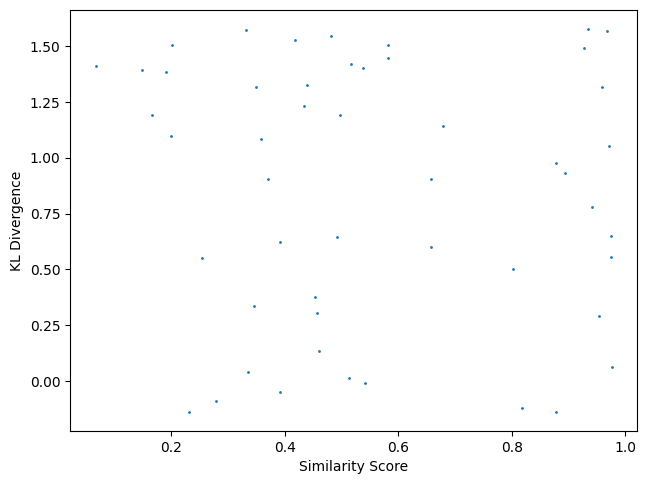

In [ ]:
fig,ax = plt.subplots(1)
fig.tight_layout()

ax.set_xlabel("Similarity Score")
ax.set_ylabel("KL Divergence")
ax.scatter(similarity, kl, s=1)